# Aadhaar Enrolment Analysis – Technical Notebook

This notebook contains the data preparation, analytical workflow, and computations that support the findings presented in the accompanying report PDF.  
It is intended for technical review and reproducibility, not as a narrative report.


## Data Loading and Schema Validation

In [124]:
!pip install duckdb


In [125]:
import duckdb
con = duckdb.connect()


In [126]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000 (2).csv


In [127]:
con.execute("""
DESCRIBE SELECT * FROM 'api_data_aadhar_enrolment_0_500000.csv'
"""
   ).df()

,column_name,column_type,null,key,default,extra
0,date,DATE,YES,None,None,None
1,state,VARCHAR,YES,None,None,None
2,district,VARCHAR,YES,None,None,None
3,pincode,BIGINT,YES,None,None,None
4,age_0_5,BIGINT,YES,None,None,None
5,age_5_17,BIGINT,YES,None,None,None
6,age_18_greater,BIGINT,YES,None,None,None


In [128]:
con.execute("""
SELECT * FROM 'api_data_aadhar_enrolment_0_500000.csv'
"""
).df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
499995,2025-10-26,Andhra Pradesh,Mahbubnagar,509207,1,0,0
499996,2025-10-26,Andhra Pradesh,Medak,502220,1,0,0
499997,2025-10-26,Andhra Pradesh,Medak,502256,0,1,0
499998,2025-10-26,Andhra Pradesh,Medak,502286,1,0,0


In [129]:
con.execute("""
CREATE
OR
REPLACE
VIEW
aadhaar_clean_step1 AS
SELECT
    CAST(date AS DATE) AS date,
    state,
    district,
    pincode,
    age_0_5,
    age_5_17,
    age_18_greater
FROM read_csv_auto('api_data_aadhar_enrolment_0_500000.csv');
""")

In [130]:
con.execute("DESCRIBE aadhaar_clean_step1").df()

,column_name,column_type,null,key,default,extra
0,date,DATE,YES,None,None,None
1,state,VARCHAR,YES,None,None,None
2,district,VARCHAR,YES,None,None,None
3,pincode,BIGINT,YES,None,None,None
4,age_0_5,BIGINT,YES,None,None,None
5,age_5_17,BIGINT,YES,None,None,None
6,age_18_greater,BIGINT,YES,None,None,None


In [131]:
con.execute("""
SELECT
    COUNT(*) FILTER (WHERE date IS NULL) AS null_date_count,
    COUNT(*) FILTER (WHERE state IS NULL) AS null_state_count,
    COUNT(*) FILTER (WHERE district IS NULL) AS null_district_count,
    COUNT(*) FILTER (WHERE pincode IS NULL) AS null_pincode_count
FROM aadhaar_clean_step1
""").df()

,null_date_count,null_state_count,null_district_count,null_pincode_count
0,0,0,0,0


In [132]:
con.execute("""
CREATE
OR
REPLACE
VIEW
aadhaar_clean_step2 AS
SELECT
    date,
    state,
    district,
    CAST(pincode AS VARCHAR) AS pincode,
    age_0_5,
    age_5_17,
    age_18_greater
FROM aadhaar_clean_step1;
""")

In [133]:
con.execute("DESCRIBE aadhaar_clean_step2").df()

,column_name,column_type,null,key,default,extra
0,date,DATE,YES,None,None,None
1,state,VARCHAR,YES,None,None,None
2,district,VARCHAR,YES,None,None,None
3,pincode,VARCHAR,YES,None,None,None
4,age_0_5,BIGINT,YES,None,None,None
5,age_5_17,BIGINT,YES,None,None,None
6,age_18_greater,BIGINT,YES,None,None,None


In [134]:
con.execute("""
SELECT
    COUNT(*) FILTER (WHERE date IS NULL) AS null_date_count,
    COUNT(*) FILTER (WHERE state IS NULL) AS null_state_count,
    COUNT(*) FILTER (WHERE district IS NULL) AS null_district_count,
    COUNT(*) FILTER (WHERE pincode IS NULL) AS null_pincode_count
FROM aadhaar_clean_step2
""").df()

,null_date_count,null_state_count,null_district_count,null_pincode_count
0,0,0,0,0


## Data Preparation

In [135]:
con.execute("""
CREATE OR REPLACE VIEW aadhaar_with_total_enrol AS
SELECT
    date,
    state,
    district,
    pincode,
    age_0_5,
    age_5_17,
    age_18_greater,
    age_0_5 + age_5_17 + age_18_greater AS total_enrol
FROM aadhaar_clean_step2;
""")

In [136]:
con.execute("""
SELECT
    SUM(total_enrol) AS overall_total_enrol,
    SUM(age_0_5) AS total_age_0_5,
    SUM(age_5_17) AS total_age_5_17,
    SUM(age_18_greater) AS total_age_18_greater
FROM aadhaar_with_total_enrol;
""").df()

,overall_total_enrol,total_age_0_5,total_age_5_17,total_age_18_greater
0,3301026.0,2020406.0,1157841.0,122779.0


In [137]:
con.execute("""
SELECT
    CAST(SUM(age_0_5) AS REAL) / SUM(total_enrol) AS share_0_5_all,
    CAST(SUM(age_5_17) AS REAL) / SUM(total_enrol) AS share_5_17_all,
    CAST(SUM(age_18_greater) AS REAL) / SUM(total_enrol) AS share_18_plus_all
FROM aadhaar_with_total_enrol;
""").df()

,share_0_5_all,share_5_17_all,share_18_plus_all
0,0.612054,0.350752,0.037194


In [138]:
con.execute("""
SELECT
    state,
    SUM(total_enrol) AS total_enrol_state,
    CAST(SUM(age_0_5) AS REAL) / SUM(total_enrol) AS share_0_5_state,
    CAST(SUM(age_5_17) AS REAL) / SUM(total_enrol) AS share_5_17_state,
    CAST(SUM(age_18_greater) AS REAL) / SUM(total_enrol) AS share_18_plus_state
FROM aadhaar_with_total_enrol
GROUP BY state
ORDER BY total_enrol_state DESC;
""").df()

,state,total_enrol_state,share_0_5_state,share_5_17_state,share_18_plus_state
0,Uttar Pradesh,670426.0,0.488023,0.492488,0.019489
1,Bihar,390901.0,0.411406,0.563271,0.025324
2,Madhya Pradesh,277081.0,0.685428,0.292362,0.022210
3,West Bengal,222260.0,0.716593,0.262692,0.020714
4,Maharashtra,222030.0,0.705364,0.270761,0.023875
5,Rajasthan,205699.0,0.666727,0.321679,0.011595
6,Gujarat,193313.0,0.638240,0.297036,0.064724
7,Assam,167163.0,0.598745,0.298601,0.102654
8,Karnataka,121762.0,0.753470,0.180409,0.066121
9,Tamil Nadu,105582.0,0.835133,0.159970,0.004897


##Statistical Thresholds


In [139]:
con.execute("""
SELECT
    MIN(total_enrol) AS min_total_enrol,
    MAX(total_enrol) AS max_total_enrol,
    AVG(total_enrol) AS mean_total_enrol,
    MEDIAN(total_enrol) AS median_total_enrol,
    QUANTILE_CONT(total_enrol, 0.90) AS p90_total_enrol
FROM aadhaar_with_total_enrol;
""").df()

,min_total_enrol,max_total_enrol,mean_total_enrol,median_total_enrol,p90_total_enrol
0,1,3965,6.602052,2.0,10.0


In [140]:
overall_total_enrolments = 3301026.0

# Re-define total_enrolments_by_state
total_enrolments_by_state = con.execute("""
SELECT
    state,
    SUM(total_enrol) AS total_enrolments
FROM aadhaar_with_total_enrol
GROUP BY state
ORDER BY total_enrolments DESC;
""").df()

top_3_states_enrolments = total_enrolments_by_state.head(3)['total_enrolments'].sum()

percentage_top_3_states = (top_3_states_enrolments / overall_total_enrolments) * 100

print(f"The top 3 states combined contribute {percentage_top_3_states:.2f}% of the total enrolments.")

The top 3 states combined contribute 40.55% of the total enrolments.


In [141]:
percentiles_df = con.execute("""
SELECT
    QUANTILE_CONT(total_enrol, 0.20) AS p20,
    QUANTILE_CONT(total_enrol, 0.80) AS p80
FROM aadhaar_with_total_enrol;
""").df()
p20 = percentiles_df['p20'].iloc[0]
p80 = percentiles_df['p80'].iloc[0]

print(f"20th Percentile (p20): {p20}")
print(f"80th Percentile (p80): {p80}")

20th Percentile (p20): 1.0
80th Percentile (p80): 6.0


In [142]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_with_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol > {p80} THEN 'high'
        WHEN total_enrol <= {p20} THEN 'low'
        ELSE 'medium'
    END AS volume_tier
FROM aadhaar_with_total_enrol;
""")

In [143]:
con.execute("SELECT * FROM aadhaar_with_volume_tiers LIMIT 10").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,volume_tier
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109,high
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,86,high
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,high
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106,high
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,51,high
5,2025-03-09,Bihar,Sitamarhi,843331,20,49,12,81,high
6,2025-03-09,Bihar,Sitamarhi,843330,23,24,42,89,high
7,2025-03-09,Uttar Pradesh,Bahraich,271865,26,60,14,100,high
8,2025-03-09,Uttar Pradesh,Firozabad,283204,28,26,10,64,high
9,2025-03-09,Bihar,Purbi Champaran,845418,30,48,10,88,high


In [144]:
con.execute("""
SELECT
    volume_tier,
    AVG(CAST(age_0_5 AS REAL) / total_enrol) AS avg_share_0_5,
    AVG(CAST(age_5_17 AS REAL) / total_enrol) AS avg_share_5_17,
    AVG(CAST(age_18_greater AS REAL) / total_enrol) AS avg_share_18_greater
FROM aadhaar_with_volume_tiers
GROUP BY volume_tier
ORDER BY volume_tier;
""").df()

,volume_tier,avg_share_0_5,avg_share_5_17,avg_share_18_greater
0,high,0.636063,0.347113,0.016825
1,low,0.768808,0.218570,0.012621
2,medium,0.722318,0.266231,0.011451


## Activity Segmentation




In [145]:
top_3_states = con.execute("""
SELECT
    state,
    SUM(total_enrol) AS total_enrol_state
FROM aadhaar_with_total_enrol
GROUP BY state
ORDER BY total_enrol_state DESC
LIMIT 3;
""").df()
print("Top 3 states by total enrolments:")
print(top_3_states)

Top 3 states by total enrolments:
            state  total_enrol_state
0   Uttar Pradesh           670426.0
1           Bihar           390901.0
2  Madhya Pradesh           277081.0


In [146]:
top_3_state_names = top_3_states['state'].tolist()

# Prepare the state names for SQL IN clause
# DuckDB uses single quotes for strings, so we join with single quotes.
sql_top_3_states = ', '.join(f"'{state}'" for state in top_3_state_names)

print(f"Top 3 states for SQL query: {sql_top_3_states}")

con.execute(f"""
SELECT
    CASE
        WHEN state IN ({sql_top_3_states}) THEN 'Top 3 States'
        ELSE 'Rest of India'
    END AS state_group,
    SUM(age_0_5) AS sum_age_0_5,
    SUM(age_5_17) AS sum_age_5_17,
    SUM(age_18_greater) AS sum_age_18_greater,
    SUM(total_enrol) AS sum_total_enrol,
    CAST(SUM(age_0_5) AS REAL) / SUM(total_enrol) AS share_0_5,
    CAST(SUM(age_5_17) AS REAL) / SUM(total_enrol) AS share_5_17,
    CAST(SUM(age_18_greater) AS REAL) / SUM(total_enrol) AS share_18_greater,
    MEDIAN(total_enrol) AS median_total_enrol
FROM aadhaar_with_total_enrol
GROUP BY state_group
ORDER BY state_group;
""").df()

Top 3 states for SQL query: 'Uttar Pradesh', 'Bihar', 'Madhya Pradesh'


,state_group,sum_age_0_5,sum_age_5_17,sum_age_18_greater,sum_total_enrol,share_0_5,share_5_17,share_18_greater,median_total_enrol
0,Rest of India,1342485.0,526473.0,93660.0,1962618.0,0.684028,0.268250,0.047722,2.0
1,Top 3 States,677921.0,631368.0,29119.0,1338408.0,0.506513,0.471731,0.021756,4.0


In [147]:
major_urban_districts = [
    'Bengaluru Urban',
    'Kanpur Nagar',
    'Mumbai Suburban',
    'Chennai',
    'Delhi',
    'Hyderabad',
    'Kolkata',
    'Ahmedabad',
    'Pune',
    'Surat',
    'Jaipur',
    'Lucknow',
    'Nagpur',
    'Indore',
    'Patna',
    'Bhopal',
    'Thane',
    'Ludhiana',
    'Agra',
    'Nashik',
    'Vadodara',
    'Faridabad',
    'Ghaziabad',
    'Meerut',
    'Rajkot',
    'Varanasi',
    'Srinagar',
    'Aurangabad',
    'Amritsar',
    'Dhanbad',
    'Allahabad',
    'Ranchi',
    'Jabalpur',
    'Coimbatore',
    'Gwalior'
]

# Prepare the district names for a SQL IN clause
sql_urban_districts = ', '.join(f"'{district}'" for district in major_urban_districts)

print(f"Defined urban districts for SQL query: {sql_urban_districts}")

Defined urban districts for SQL query: 'Bengaluru Urban', 'Kanpur Nagar', 'Mumbai Suburban', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Ahmedabad', 'Pune', 'Surat', 'Jaipur', 'Lucknow', 'Nagpur', 'Indore', 'Patna', 'Bhopal', 'Thane', 'Ludhiana', 'Agra', 'Nashik', 'Vadodara', 'Faridabad', 'Ghaziabad', 'Meerut', 'Rajkot', 'Varanasi', 'Srinagar', 'Aurangabad', 'Amritsar', 'Dhanbad', 'Allahabad', 'Ranchi', 'Jabalpur', 'Coimbatore', 'Gwalior'


In [148]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_with_urban_proxy AS
SELECT
    *,
    CASE
        WHEN district IN ({sql_urban_districts}) THEN TRUE
        ELSE FALSE
    END AS urban_proxy_flag
FROM aadhaar_with_total_enrol;
""")

In [149]:
con.execute("SELECT * FROM aadhaar_with_urban_proxy LIMIT 10").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,urban_proxy_flag
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109,False
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,86,True
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,True
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106,False
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,51,True
5,2025-03-09,Bihar,Sitamarhi,843331,20,49,12,81,False
6,2025-03-09,Bihar,Sitamarhi,843330,23,24,42,89,False
7,2025-03-09,Uttar Pradesh,Bahraich,271865,26,60,14,100,False
8,2025-03-09,Uttar Pradesh,Firozabad,283204,28,26,10,64,False
9,2025-03-09,Bihar,Purbi Champaran,845418,30,48,10,88,False


In [150]:
con.execute("""
SELECT
    urban_proxy_flag,
    SUM(age_0_5) AS sum_age_0_5,
    SUM(age_5_17) AS sum_age_5_17,
    SUM(age_18_greater) AS sum_age_18_greater,
    SUM(total_enrol) AS sum_total_enrol,
    CAST(SUM(age_0_5) AS REAL) / SUM(total_enrol) AS share_0_5,
    CAST(SUM(age_5_17) AS REAL) / SUM(total_enrol) AS share_5_17,
    CAST(SUM(age_18_greater) AS REAL) / SUM(total_enrol) AS share_18_greater
FROM aadhaar_with_urban_proxy
GROUP BY urban_proxy_flag
ORDER BY urban_proxy_flag DESC;
""").df()

,urban_proxy_flag,sum_age_0_5,sum_age_5_17,sum_age_18_greater,sum_total_enrol,share_0_5,share_5_17,share_18_greater
0,True,263595.0,153339.0,14592.0,431526.0,0.610844,0.355341,0.033815
1,False,1756811.0,1004502.0,108187.0,2869500.0,0.612236,0.350062,0.037702


In [151]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_top_3_states AS
SELECT
    *
FROM aadhaar_with_total_enrol
WHERE state IN ({sql_top_3_states});
""")

In [152]:
con.execute("SELECT DISTINCT state FROM aadhaar_top_3_states").df()

,state
0,Bihar
1,Madhya Pradesh
2,Uttar Pradesh


In [153]:
percentiles_top_3_df = con.execute("""
SELECT
    QUANTILE_CONT(total_enrol, 0.20) AS p20,
    QUANTILE_CONT(total_enrol, 0.80) AS p80
FROM aadhaar_top_3_states;
""").df()
p20_top_3_states = percentiles_top_3_df['p20'].iloc[0]
p80_top_3_states = percentiles_top_3_df['p80'].iloc[0]

print(f"20th Percentile (p20) for Top 3 States: {p20_top_3_states}")
print(f"80th Percentile (p80) for Top 3 States: {p80_top_3_states}")

20th Percentile (p20) for Top 3 States: 2.0
80th Percentile (p80) for Top 3 States: 10.0


In [154]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_top_3_states_with_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol > {p80_top_3_states} THEN 'high'
        WHEN total_enrol <= {p20_top_3_states} THEN 'low'
        ELSE 'medium'
    END AS volume_tier
FROM aadhaar_top_3_states;
""")

In [155]:
con.execute("SELECT * FROM aadhaar_top_3_states_with_volume_tiers LIMIT 5").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,volume_tier
0,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,high
1,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106,high
2,2025-03-09,Bihar,Sitamarhi,843331,20,49,12,81,high
3,2025-03-09,Bihar,Sitamarhi,843330,23,24,42,89,high
4,2025-03-09,Uttar Pradesh,Bahraich,271865,26,60,14,100,high


In [156]:
con.execute("""
SELECT
    state,
    volume_tier,
    AVG(CAST(age_0_5 AS REAL) / total_enrol) AS avg_share_0_5
FROM aadhaar_top_3_states_with_volume_tiers
WHERE volume_tier IN ('high', 'low')
GROUP BY state, volume_tier
ORDER BY state, volume_tier;
""").df()

,state,volume_tier,avg_share_0_5
0,Bihar,high,0.445612
1,Bihar,low,0.408618
2,Madhya Pradesh,high,0.742496
3,Madhya Pradesh,low,0.774644
4,Uttar Pradesh,high,0.484783
5,Uttar Pradesh,low,0.497263


In [157]:
percentiles_extreme_df = con.execute("""
SELECT
    QUANTILE_CONT(total_enrol, 0.01) AS p01,
    QUANTILE_CONT(total_enrol, 0.99) AS p99
FROM aadhaar_with_total_enrol;
""").df()
p01 = percentiles_extreme_df['p01'].iloc[0]
p99 = percentiles_extreme_df['p99'].iloc[0]

print(f"1st Percentile (p01): {p01}")
print(f"99th Percentile (p99): {p99}")

1st Percentile (p01): 1.0
99th Percentile (p99): 38.0


In [158]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_with_extreme_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol <= {p01} THEN 'bottom_1_percent'
        WHEN total_enrol > {p99} THEN 'top_1_percent'
        ELSE 'middle'
    END AS volume_tier
FROM aadhaar_with_total_enrol;
""")

In [159]:
con.execute("SELECT * FROM aadhaar_with_extreme_volume_tiers LIMIT 10").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,volume_tier
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109,top_1_percent
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,86,top_1_percent
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,top_1_percent
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106,top_1_percent
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,51,top_1_percent
5,2025-03-09,Bihar,Sitamarhi,843331,20,49,12,81,top_1_percent
6,2025-03-09,Bihar,Sitamarhi,843330,23,24,42,89,top_1_percent
7,2025-03-09,Uttar Pradesh,Bahraich,271865,26,60,14,100,top_1_percent
8,2025-03-09,Uttar Pradesh,Firozabad,283204,28,26,10,64,top_1_percent
9,2025-03-09,Bihar,Purbi Champaran,845418,30,48,10,88,top_1_percent


In [160]:
con.execute("""
SELECT
    volume_tier,
    AVG(CAST(age_0_5 AS REAL) / total_enrol) AS avg_share_0_5,
    AVG(CAST(age_5_17 AS REAL) / total_enrol) AS avg_share_5_17,
    AVG(CAST(age_18_greater AS REAL) / total_enrol) AS avg_share_18_greater
FROM aadhaar_with_extreme_volume_tiers
GROUP BY volume_tier
ORDER BY volume_tier;
""").df()

,volume_tier,avg_share_0_5,avg_share_5_17,avg_share_18_greater
0,bottom_1_percent,0.768808,0.218570,0.012621
1,middle,0.701335,0.286931,0.011733
2,top_1_percent,0.549843,0.363685,0.086472


In [161]:
con.execute("""
SELECT
    state,
    volume_tier,
    MEDIAN(CAST(age_0_5 AS REAL) / total_enrol) AS median_share_0_5
FROM aadhaar_top_3_states_with_volume_tiers
WHERE volume_tier IN ('high', 'low')
GROUP BY state, volume_tier
ORDER BY state, volume_tier;
""").df()

,state,volume_tier,median_share_0_5
0,Bihar,high,0.444444
1,Bihar,low,0.000000
2,Madhya Pradesh,high,0.769231
3,Madhya Pradesh,low,1.000000
4,Uttar Pradesh,high,0.479152
5,Uttar Pradesh,low,0.500000


In [162]:
con.execute("""
SELECT
    state,
    volume_tier,
    AVG(CAST(age_5_17 AS REAL) / total_enrol) AS avg_share_5_17,
    AVG(CAST(age_18_greater AS REAL) / total_enrol) AS avg_share_18_greater
FROM aadhaar_top_3_states_with_volume_tiers
WHERE volume_tier IN ('high', 'low')
GROUP BY state, volume_tier
ORDER BY state, volume_tier;
""").df()

,state,volume_tier,avg_share_5_17,avg_share_18_greater
0,Bihar,high,0.541338,0.013050
1,Bihar,low,0.570864,0.020518
2,Madhya Pradesh,high,0.245902,0.011602
3,Madhya Pradesh,low,0.215278,0.010079
4,Uttar Pradesh,high,0.502783,0.012435
5,Uttar Pradesh,low,0.489226,0.013511


In [163]:
con.execute("DESCRIBE aadhaar_top_3_states_with_volume_tiers").df()

,column_name,column_type,null,key,default,extra
0,date,DATE,YES,None,None,None
1,state,VARCHAR,YES,None,None,None
2,district,VARCHAR,YES,None,None,None
3,pincode,VARCHAR,YES,None,None,None
4,age_0_5,BIGINT,YES,None,None,None
5,age_5_17,BIGINT,YES,None,None,None
6,age_18_greater,BIGINT,YES,None,None,None
7,total_enrol,BIGINT,YES,None,None,None
8,volume_tier,VARCHAR,YES,None,None,None


In [164]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_top_3_states_with_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol > {p80_top_3_states} THEN 'high'
        WHEN total_enrol <= {p20_top_3_states} THEN 'low'
        ELSE 'medium'
    END AS volume_tier
FROM aadhaar_top_3_states;
""")
con.execute("DESCRIBE aadhaar_top_3_states_with_volume_tiers").df()

,column_name,column_type,null,key,default,extra
0,date,DATE,YES,None,None,None
1,state,VARCHAR,YES,None,None,None
2,district,VARCHAR,YES,None,None,None
3,pincode,VARCHAR,YES,None,None,None
4,age_0_5,BIGINT,YES,None,None,None
5,age_5_17,BIGINT,YES,None,None,None
6,age_18_greater,BIGINT,YES,None,None,None
7,total_enrol,BIGINT,YES,None,None,None
8,volume_tier,VARCHAR,YES,None,None,None


In [165]:
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_top_3_states AS
SELECT
    *
FROM aadhaar_with_total_enrol
WHERE state IN ({sql_top_3_states});
""")

con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_top_3_states_with_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol > {p80_top_3_states} THEN 'high'
        WHEN total_enrol <= {p20_top_3_states} THEN 'low'
        ELSE 'medium'
    END AS volume_tier
FROM aadhaar_top_3_states;
""")

con.execute("DESCRIBE aadhaar_top_3_states_with_volume_tiers").df()
con.execute("SELECT * FROM aadhaar_top_3_states_with_volume_tiers LIMIT 5").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,volume_tier
0,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123,high
1,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,106,high
2,2025-03-09,Bihar,Sitamarhi,843331,20,49,12,81,high
3,2025-03-09,Bihar,Sitamarhi,843330,23,24,42,89,high
4,2025-03-09,Uttar Pradesh,Bahraich,271865,26,60,14,100,high


In [166]:
con.execute("""
CREATE OR REPLACE TEMPORARY VIEW median_age_0_5_low_volume AS
SELECT
    state,
    MEDIAN(CAST(age_0_5 AS REAL) / total_enrol) AS median_share_0_5_low
FROM aadhaar_top_3_states_with_volume_tiers
WHERE volume_tier = 'low'
GROUP BY state;
""")

In [167]:
con.execute("SELECT * FROM median_age_0_5_low_volume").df()

,state,median_share_0_5_low
0,Madhya Pradesh,1.0
1,Uttar Pradesh,0.5
2,Bihar,0.0


## Indicator Construction




In [168]:
con.execute("""
CREATE OR REPLACE VIEW aadhaar_with_child_under_focus_flag AS
SELECT
    t.*,
    CASE
        WHEN (CAST(t.age_0_5 AS REAL) / t.total_enrol) < (m.median_share_0_5_low - 0.05) THEN 1
        ELSE 0
    END AS child_under_focus_flag
FROM aadhaar_top_3_states_with_volume_tiers t
JOIN median_age_0_5_low_volume m ON t.state = m.state
WHERE t.volume_tier = 'low';
""")

con.execute("SELECT * FROM aadhaar_with_child_under_focus_flag LIMIT 10").df()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrol,volume_tier,child_under_focus_flag
0,2025-09-13,Bihar,Lakhisarai,811309,0,2,0,2,low,0
1,2025-09-13,Bihar,Madhepura,852121,0,2,0,2,low,0
2,2025-09-13,Bihar,Madhubani,843319,1,0,0,1,low,0
3,2025-09-13,Bihar,Madhubani,847122,1,0,0,1,low,0
4,2025-09-13,Bihar,Madhubani,847240,0,1,0,1,low,0
5,2025-09-13,Bihar,Madhubani,847421,0,1,0,1,low,0
6,2025-09-13,Bihar,Monghyr,811213,1,0,0,1,low,0
7,2025-09-13,Bihar,Muzaffarpur,843113,1,1,0,2,low,0
8,2025-09-13,Bihar,Nalanda,801301,1,1,0,2,low,0
9,2025-09-13,Bihar,Nalanda,801304,2,0,0,2,low,0


In [169]:
con.execute("""
SELECT
    state,
    COUNT(*) AS total_low_volume_pincodes,
    SUM(CASE WHEN child_under_focus_flag = 1 THEN 1 ELSE 0 END) AS flagged_pincodes_count,
    (CAST(SUM(CASE WHEN child_under_focus_flag = 1 THEN 1 ELSE 0 END) AS REAL) * 100) / COUNT(*) AS percentage_flagged_pincodes
FROM aadhaar_with_child_under_focus_flag
GROUP BY state
ORDER BY state;
""").df()

,state,total_low_volume_pincodes,flagged_pincodes_count,percentage_flagged_pincodes
0,Bihar,9236,0.0,0.000000
1,Madhya Pradesh,8136,2324.0,28.564405
2,Uttar Pradesh,19909,8263.0,41.503841


## Data Visualization




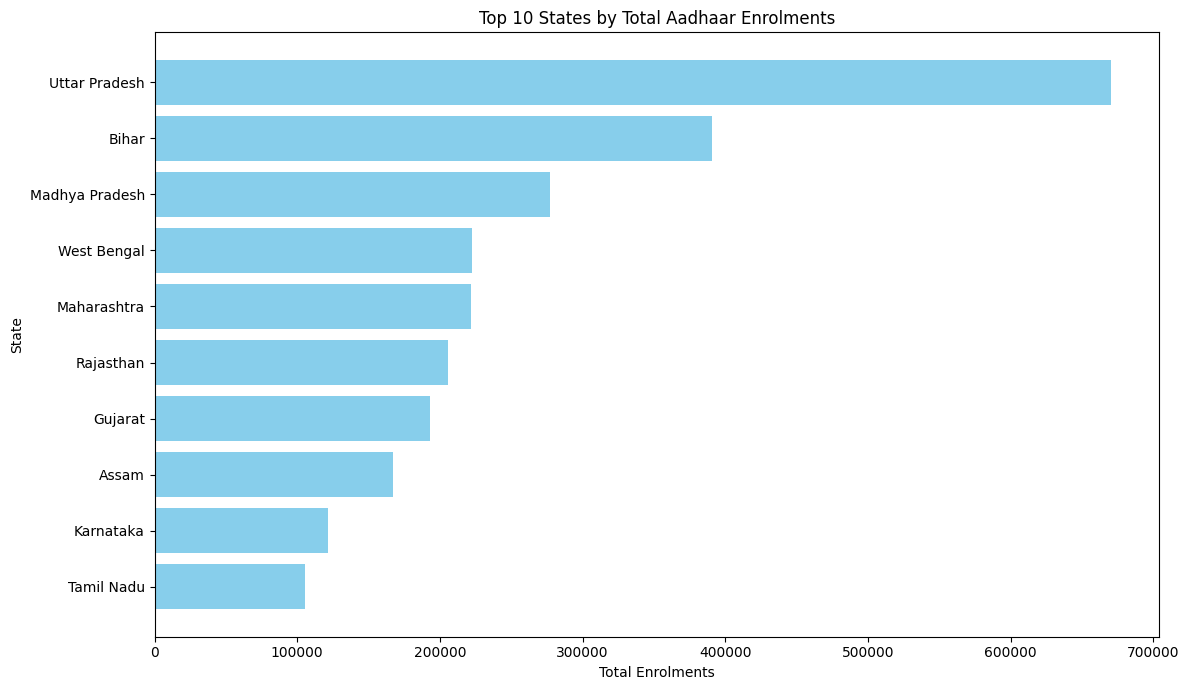

The top 3 states (Uttar Pradesh, Bihar, Madhya Pradesh) account for 40.55% of total enrolments, highlighting a clear geographic concentration.


In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.barh(total_enrolments_by_state['state'].head(10), total_enrolments_by_state['total_enrolments'].head(10), color='skyblue')
plt.xlabel('Total Enrolments')
plt.ylabel('State')
plt.title('Top 10 States by Total Aadhaar Enrolments')
plt.gca().invert_yaxis() # Invert y-axis to have the highest value on top
plt.tight_layout()
plt.show()

print(f"The top 3 states (Uttar Pradesh, Bihar, Madhya Pradesh) account for {percentage_top_3_states:.2f}% of total enrolments, highlighting a clear geographic concentration.")

##  National Age Distribution




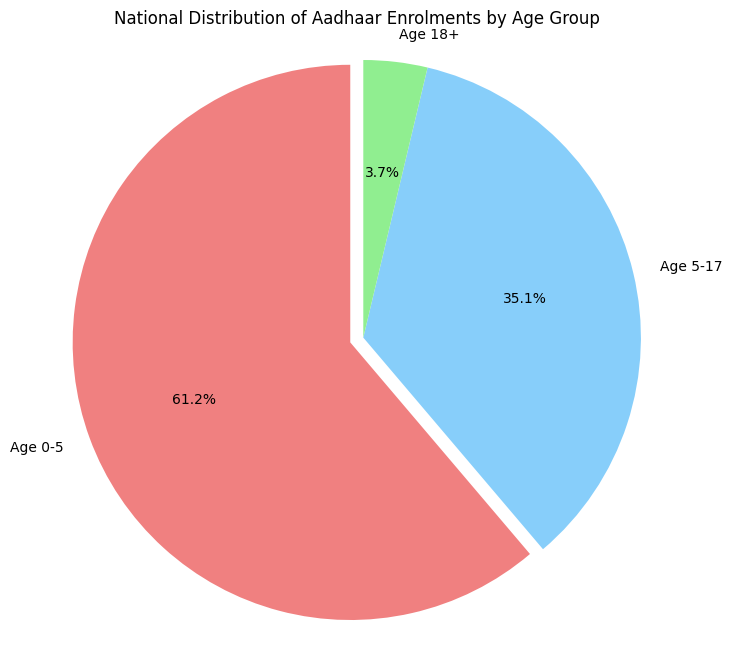

The national distribution shows a significant majority of enrolments concentrated in the younger age groups.


In [171]:
import matplotlib.pyplot as plt

# Data for Chart 2: National Age Distribution
# Re-executing the SQL query to ensure the data is fresh in case of kernel restarts
national_age_shares = con.execute("""
SELECT
    CAST(SUM(age_0_5) AS REAL) / SUM(total_enrol) AS share_0_5_all,
    CAST(SUM(age_5_17) AS REAL) / SUM(total_enrol) AS share_5_17_all,
    CAST(SUM(age_18_greater) AS REAL) / SUM(total_enrol) AS share_18_plus_all
FROM aadhaar_with_total_enrol;
""").df()

shares = national_age_shares.iloc[0].tolist()
labels = ['Age 0-5', 'Age 5-17', 'Age 18+']
colors = ['lightcoral', 'lightskyblue', 'lightgreen']

plt.figure(figsize=(8, 8))
plt.pie(shares, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0])
plt.title('National Distribution of Aadhaar Enrolments by Age Group')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print("The national distribution shows a significant majority of enrolments concentrated in the younger age groups.")

##  Enrolment Trend Over Time




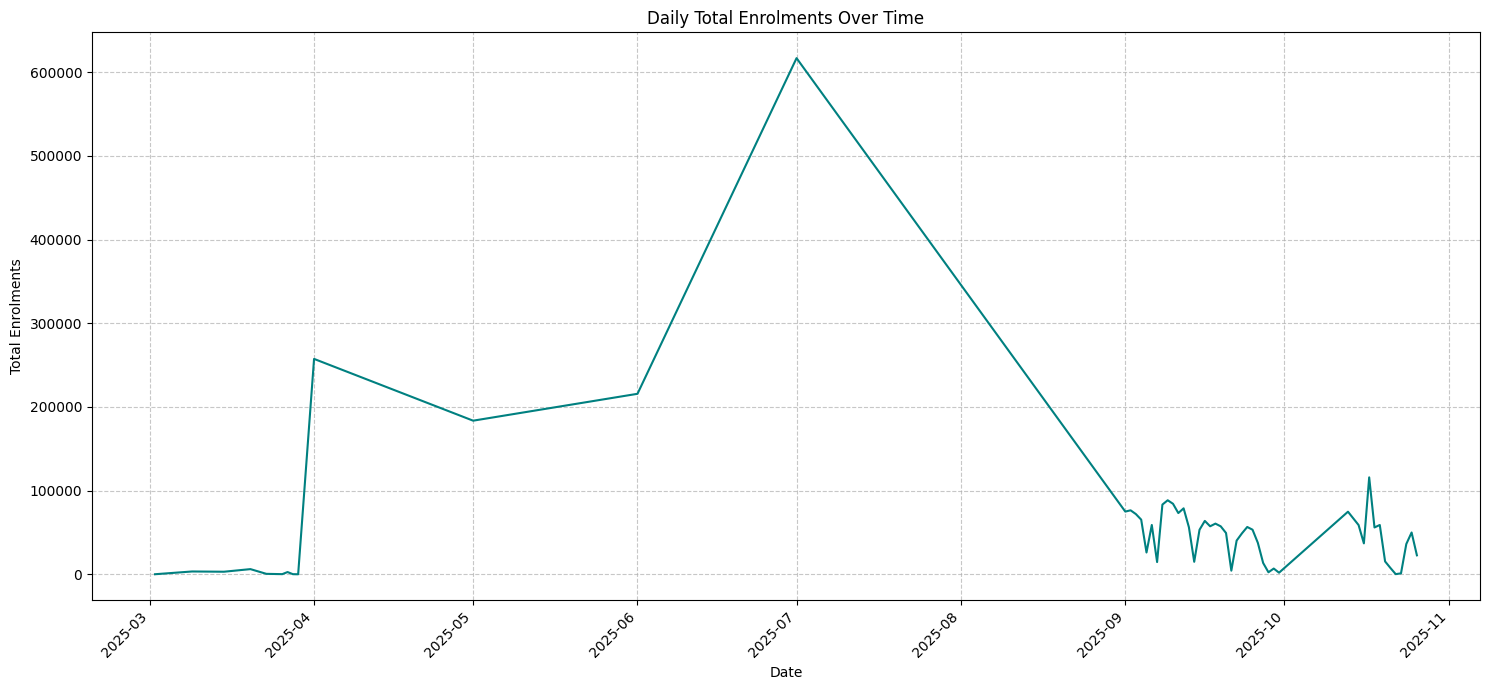

The daily enrolment data shows significant volatility, with noticeable spikes and dips throughout the period, suggesting a non-stable enrolment activity.


In [172]:
import matplotlib.pyplot as plt

# 1. Execute a DuckDB query to select the 'date' and the sum of 'total_enrol'
# (aliased as 'daily_total') from the aadhaar_with_total_enrol view.
# Group the results by 'date' and order them chronologically.
# 2. Store the query result in a pandas DataFrame.
daily_enrolments_df = con.execute("""
SELECT
    date,
    SUM(total_enrol) AS daily_total
FROM aadhaar_with_total_enrol
GROUP BY date
ORDER BY date;
""").df()

# 4. Create a line plot using the 'date' column on the x-axis and 'daily_total' on the y-axis from the DataFrame.
plt.figure(figsize=(15, 7))
plt.plot(daily_enrolments_df['date'], daily_enrolments_df['daily_total'], color='teal')

# 5. Add a title to the plot
plt.title('Daily Total Enrolments Over Time')

# 6. Label the x-axis as 'Date' and the y-axis as 'Total Enrolments'.
plt.xlabel('Date')
plt.ylabel('Total Enrolments')

# Improve date formatting on x-axis for better readability
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# 7. Display the plot.
plt.show()

# 8. Print a concise insight focusing on observed trends, seasonality, or any significant spikes in the daily enrolment data.
print("The daily enrolment data shows significant volatility, with noticeable spikes and dips throughout the period, suggesting a non-stable enrolment activity.")

##  Activity Tier Distribution by State




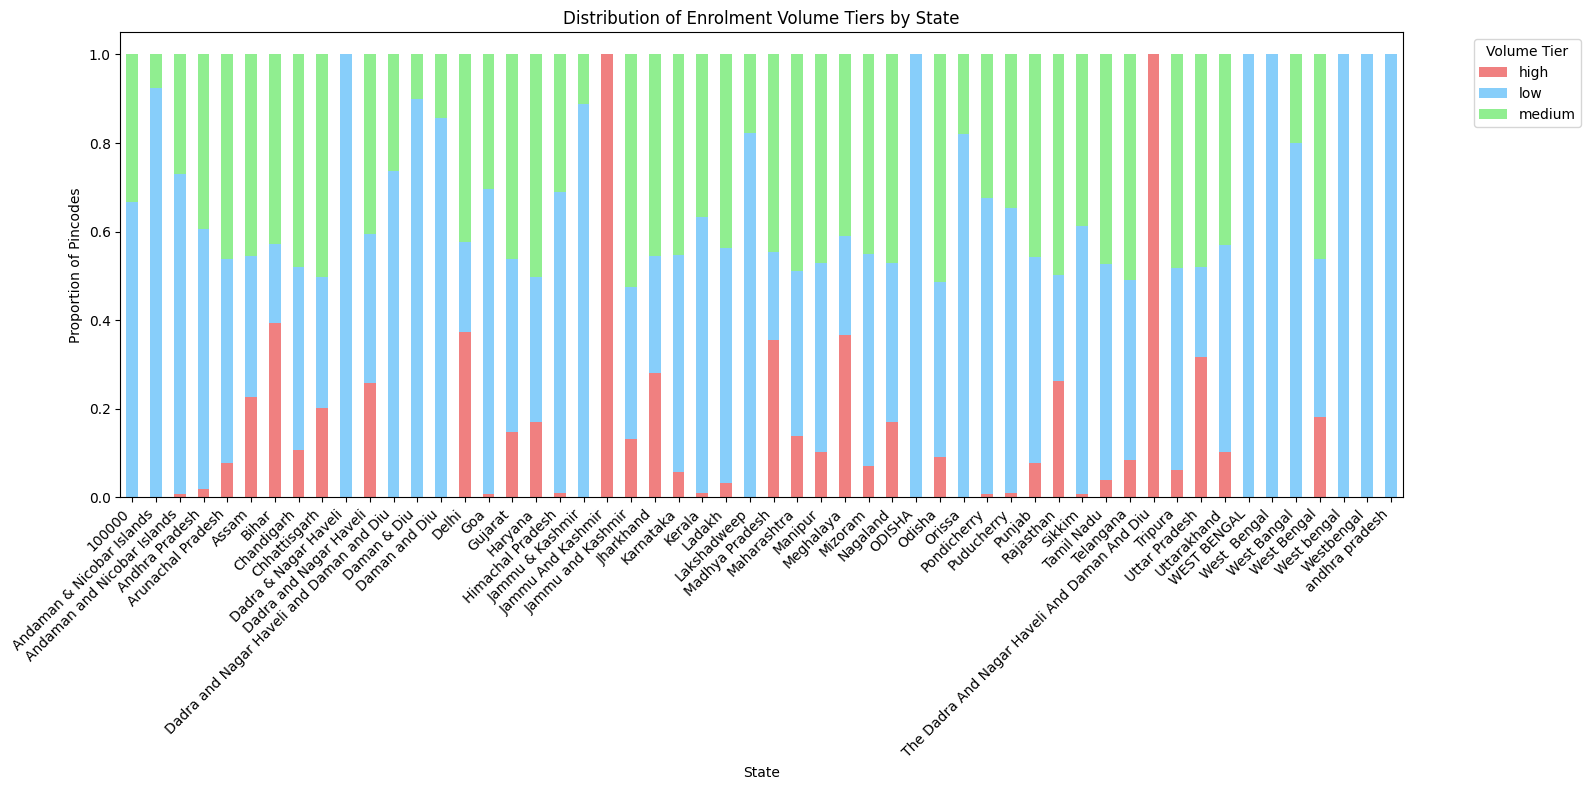

The stacked bar chart reveals varied concentrations of enrolment volume tiers across states. Some states exhibit a higher proportion of low-volume pincodes, while others have a more balanced distribution or a higher share of high-volume areas, suggesting diverse activity levels and enrolment penetration.


In [173]:
import matplotlib.pyplot as plt
import pandas as pd

# Re-calculate p20 and p80 for the entire dataset
percentiles_df = con.execute("""
SELECT
    QUANTILE_CONT(total_enrol, 0.20) AS p20,
    QUANTILE_CONT(total_enrol, 0.80) AS p80
FROM aadhaar_with_total_enrol;
""").df()
p20 = percentiles_df['p20'].iloc[0]
p80 = percentiles_df['p80'].iloc[0]

# Re-create the aadhaar_with_volume_tiers view
con.execute(f"""
CREATE OR REPLACE VIEW aadhaar_with_volume_tiers AS
SELECT
    *,
    CASE
        WHEN total_enrol > {p80} THEN 'high'
        WHEN total_enrol <= {p20} THEN 'low'
        ELSE 'medium'
    END AS volume_tier
FROM aadhaar_with_total_enrol;
""")

# 1. Execute a SQL query on the aadhaar_with_volume_tiers view to count the number of pincodes
#    for each volume_tier per state.
volume_tier_distribution = con.execute("""
SELECT
    state,
    volume_tier,
    COUNT(pincode) AS pincode_count
FROM aadhaar_with_volume_tiers
GROUP BY state, volume_tier
ORDER BY state, volume_tier;
""").df()

# 2. Use the pivot_table function from pandas to reshape the data
#    so that states are rows, volume tiers are columns, and values are the counts.
#    Then, normalize to show proportions within each state.
volume_tier_pivot = volume_tier_distribution.pivot_table(
    index='state',
    columns='volume_tier',
    values='pincode_count',
    fill_value=0
)

# Calculate proportions within each state
volume_tier_proportions = volume_tier_pivot.div(volume_tier_pivot.sum(axis=1), axis=0)

# 3. Create a stacked bar chart using matplotlib.pyplot
# 4. Add a title to the plot.
# 5. Label the x-axis as 'State' and the y-axis as 'Proportion of Pincodes'.
# 6. Add a legend to differentiate between volume tiers.
# 7. Rotate x-axis labels by 45 degrees for better readability.
# 8. Display the plot.

plt.figure(figsize=(16, 8))
volume_tier_proportions.plot(kind='bar', stacked=True, ax=plt.gca(), color=['lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Distribution of Enrolment Volume Tiers by State')
plt.xlabel('State')
plt.ylabel('Proportion of Pincodes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Volume Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 9. Print a concise insight below the chart, focusing on which states show a higher concentration of low or high activity.
print("The stacked bar chart reveals varied concentrations of enrolment volume tiers across states. Some states exhibit a higher proportion of low-volume pincodes, while others have a more balanced distribution or a higher share of high-volume areas, suggesting diverse activity levels and enrolment penetration.")

##  Child Under-Focus Indicator




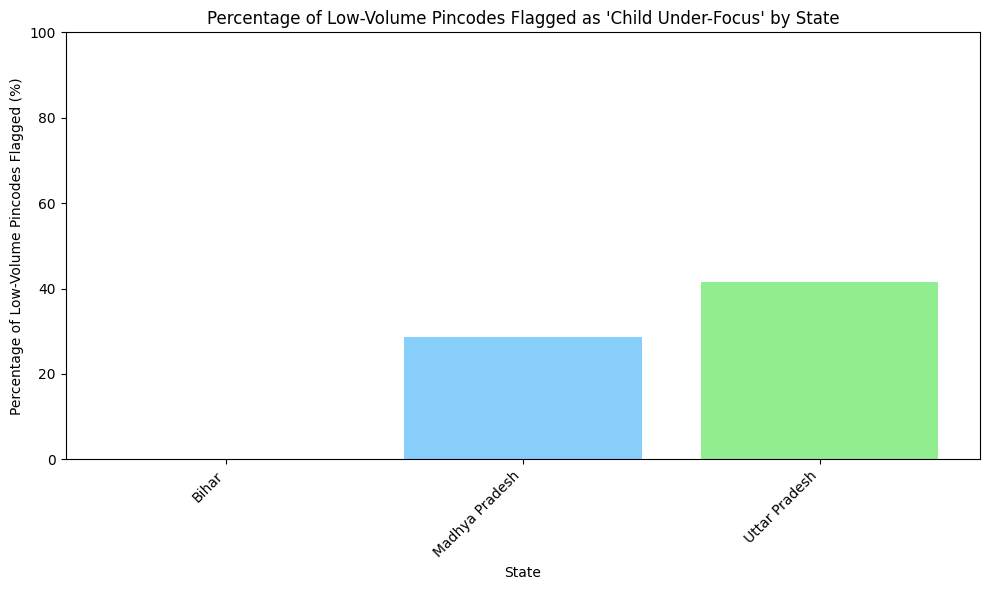

Uttar Pradesh and Madhya Pradesh show a substantial percentage of low-volume pincodes where child enrolments are under-focused, suggesting a need for targeted interventions. Bihar's 0% flagged pincodes, despite a low median `age_0_5` share in low-volume areas, warrants further investigation into its specific enrolment dynamics or data characteristics.


In [174]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for Child Under-Focus Flag Indicator Summary (re-running query to ensure data freshness)
child_focus_summary = con.execute("""
SELECT
    state,
    COUNT(*) AS total_low_volume_pincodes,
    SUM(CASE WHEN child_under_focus_flag = 1 THEN 1 ELSE 0 END) AS flagged_pincodes_count,
    (CAST(SUM(CASE WHEN child_under_focus_flag = 1 THEN 1 ELSE 0 END) AS REAL) * 100) / COUNT(*) AS percentage_flagged_pincodes
FROM aadhaar_with_child_under_focus_flag
GROUP BY state
ORDER BY state;
""").df()

plt.figure(figsize=(10, 6))
plt.bar(child_focus_summary['state'], child_focus_summary['percentage_flagged_pincodes'], color=['lightcoral', 'lightskyblue', 'lightgreen'])
plt.xlabel('State')
plt.ylabel('Percentage of Low-Volume Pincodes Flagged (%)')
plt.title('Percentage of Low-Volume Pincodes Flagged as \'Child Under-Focus\' by State')
plt.ylim(0, 100) # Percentage from 0 to 100
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Uttar Pradesh and Madhya Pradesh show a substantial percentage of low-volume pincodes where child enrolments are under-focused, suggesting a need for targeted interventions. Bihar's 0% flagged pincodes, despite a low median `age_0_5` share in low-volume areas, warrants further investigation into its specific enrolment dynamics or data characteristics.")

## Summary:

### Q&A

*   **Where is Aadhaar activity concentrated?**
    Aadhaar activity is heavily concentrated in specific states, with Uttar Pradesh, Bihar, and Madhya Pradesh collectively accounting for 40.55% of total enrolments.
*   **Who is the system serving most?**
    The Aadhaar system is primarily serving the younger age groups, as indicated by the national distribution of enrolments by age.
*   **Is enrolment activity stable, rising, or volatile?**
    The daily enrolment data shows significant volatility, characterized by noticeable spikes and dips throughout the period, suggesting non-stable enrolment activity.
*   **Where are child enrolments low despite activity?**
    Uttar Pradesh and Madhya Pradesh show a substantial percentage of low-volume pincodes (41.50% and 28.56% respectively) where child enrolments are under-focused. Bihar, surprisingly, has 0% flagged pincodes despite having a low median age 0-5 share in low-volume areas.

### Data Analysis Key Findings

*   **Geographic Concentration**: The top 3 states (Uttar Pradesh, Bihar, Madhya Pradesh) account for 40.55% of total Aadhaar enrolments, highlighting a clear geographic concentration.
*   **Age Distribution**: A significant majority of national Aadhaar enrolments are concentrated in the younger age groups.
*   **Enrolment Volatility**: Daily enrolment activity is highly volatile, exhibiting significant spikes and dips rather than a stable or steadily rising trend.
*   **State-wise Activity Tiers**: The distribution of enrolment volume tiers (low, medium, high) varies significantly by state, indicating diverse activity levels and enrolment penetration across regions.
*   **Child Enrolment Gaps**:
    *   In Uttar Pradesh, 41.50% of low-volume pincodes are flagged for under-focused child enrolments.
    *   In Madhya Pradesh, 28.56% of low-volume pincodes are flagged for under-focused child enrolments.
    *   Bihar shows 0% of its low-volume pincodes flagged for child under-focus, which warrants further investigation.

### Insights or Next Steps

*   Targeted interventions should be implemented in Uttar Pradesh and Madhya Pradesh to address the identified gaps in child enrolments within low-volume pincodes.
*   Further investigation is needed into Bihar's enrolment dynamics and data characteristics, specifically regarding child enrolments in low-volume areas, given its 0% flagged pincodes despite general low child enrolment share.
